In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [56]:
df = pd.read_csv('./Leukemia_GSE9476.csv')

In [57]:
df.shape

(64, 22285)

In [58]:
df.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,1,Bone_Marrow_CD34,7.745245,7.811210,6.477916,8.841506,4.546941,7.957714,5.344999,4.673364,...,5.058849,6.810004,12.800060,12.718612,5.391512,4.666166,3.974759,3.656693,4.160622,4.139249
1,12,Bone_Marrow_CD34,8.087252,7.240673,8.584648,8.983571,4.548934,8.011652,5.579647,4.828184,...,4.436153,6.751471,12.472706,12.333593,5.379738,4.656786,4.188348,3.792535,4.204414,4.122700
2,13,Bone_Marrow_CD34,7.792056,7.549368,11.053504,8.909703,4.549328,8.237099,5.406489,4.615572,...,4.392061,6.086295,12.637384,12.499038,5.316604,4.600566,3.845561,3.635715,4.174199,4.067152
3,14,Bone_Marrow_CD34,7.767265,7.094460,11.816433,8.994654,4.697018,8.283412,5.582195,4.903684,...,4.633334,6.375991,12.903630,12.871454,5.179951,4.641952,3.991634,3.704587,4.149938,3.910150
4,15,Bone_Marrow_CD34,8.010117,7.405281,6.656049,9.050682,4.514986,8.377046,5.493713,4.860754,...,5.305192,6.700453,12.949352,12.782515,5.341689,4.560315,3.887020,3.629853,4.127513,4.004316


In [59]:
scaler = StandardScaler()

In [60]:
df_X = df.drop('type', axis=1)

In [61]:
X = scaler.fit_transform(df_X)

In [62]:
pca = PCA(n_components=0.95)

In [63]:
X_pca = pca.fit_transform(X)

<AxesSubplot:>

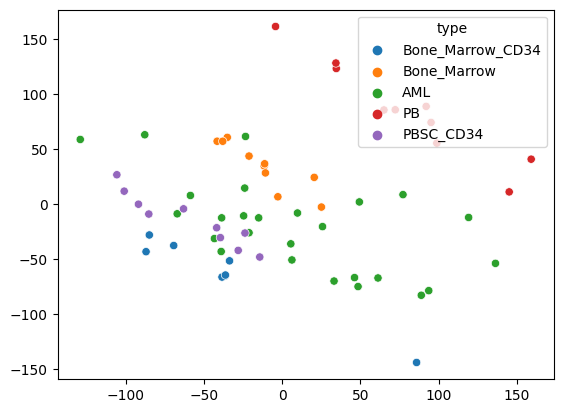

In [64]:
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['type'])

In [65]:
pca.n_components_

47

In [66]:
pca.explained_variance_ratio_.cumsum().shape

(47,)

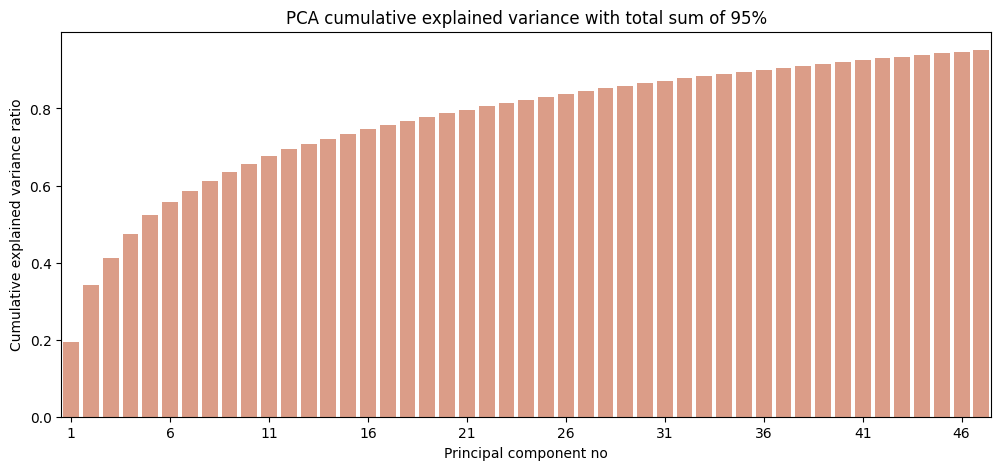

In [67]:
plt.figure(figsize=(12, 5))
sns.barplot(
    x=np.arange(1, pca.n_components_ + 1),
    y=pca.explained_variance_ratio_.cumsum(),
    color='darksalmon',
    )
plt.xticks(np.arange(0, pca.n_components_ + 1, 5))
plt.title('PCA cumulative explained variance with total sum of 95%')
plt.xlabel('Principal component no')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

In [87]:
pca.components_

(64, 47)

In [88]:
from sklearn.manifold import TSNE

In [90]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

c:\Users\Alex\anaconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Alex\anaconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

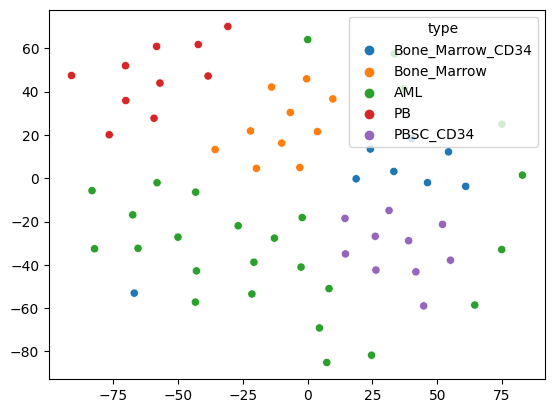

In [91]:
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['type'])